In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import spatialpandas as sp
import datashader as ds
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt
import geopandas as gpd
import pygeos
import math
import time
import warnings
import cv2
import glob
import dask
import matplotlib.colors

from shapely import wkt
from shapely.geometry import box
from pyproj import Transformer
from spatialpandas import GeoDataFrame

In [2]:
transformer = Transformer.from_crs(3395, 4326)
invtransformer = Transformer.from_crs(4326,3395)

In [3]:
# https://github.com/holoviz/datashader/issues/1006

import datashader as ds
from datashader.core import bypixel

def get_flat_coords_offset_arrays(arr):
    """
    Version for MultiPolygon data
    """
    # explode/flatten the MultiPolygons
    arr_flat, part_indices = pygeos.get_parts(arr, return_index=True)
    # the offsets into the multipolygon parts
    offsets1 = np.insert(np.bincount(part_indices).cumsum(), 0, 0)

    # explode/flatten the Polygons into Rings
    arr_flat2, ring_indices = pygeos.geometry.get_rings(arr_flat, return_index=True)
    # the offsets into the exterior/interior rings of the multipolygon parts 
    offsets2 = np.insert(np.bincount(ring_indices).cumsum(), 0, 0)

    # the coords and offsets into the coordinates of the rings
    coords, indices = pygeos.get_coordinates(arr_flat2, return_index=True)
    offsets3 = np.insert(np.bincount(indices).cumsum(), 0, 0)
    
    return coords, offsets1, offsets2, offsets3

def spatialpandas_from_pygeos(arr):
    coords, offsets1, offsets2, offsets3 = get_flat_coords_offset_arrays(arr)
    coords_flat = coords.ravel()
    offsets3 *= 2
    
    # create a pyarrow array from this
    _parr3 = pa.ListArray.from_arrays(pa.array(offsets3), pa.array(coords_flat))
    _parr2 = pa.ListArray.from_arrays(pa.array(offsets2), _parr3)
    parr = pa.ListArray.from_arrays(pa.array(offsets1), _parr2)
    
    return sp.geometry.MultiPolygonArray(parr)

def polygons(self, source, geometry, agg=None):
    from datashader.glyphs import PolygonGeom
    from datashader.reductions import any as any_rdn
    from spatialpandas import GeoDataFrame
    from spatialpandas.dask import DaskGeoDataFrame
    if isinstance(source, DaskGeoDataFrame):
        # Downselect partitions to those that may contain polygons in viewport
        x_range = self.x_range if self.x_range is not None else (None, None)
        y_range = self.y_range if self.y_range is not None else (None, None)
        source = source.cx_partitions[slice(*x_range), slice(*y_range)]
    elif isinstance(source, gpd.GeoDataFrame):
        # Downselect actual rows to those for which the polygon is in viewport
        x_range = self.x_range if self.x_range is not None else (None, None)
        y_range = self.y_range if self.y_range is not None else (None, None)
        source = source.cx[slice(*x_range), slice(*y_range)]
        # Convert the subset to ragged array format of spatialpandas
        geometries = spatialpandas_from_pygeos(source.geometry.array.data)
        source = pd.DataFrame(source)
        source["geometry"] = geometries
    elif not isinstance(source, GeoDataFrame):
        raise ValueError(
            "source must be an instance of spatialpandas.GeoDataFrame or \n"
            "spatialpandas.dask.DaskGeoDataFrame.\n"
            "  Received value of type {typ}".format(typ=type(source)))

    if agg is None:
        agg = any_rdn()
    glyph = PolygonGeom(geometry)
    return bypixel(source, self, glyph, agg)

ds.Canvas.polygons = polygons
cvs = ds.Canvas(plot_width=256, plot_height=256)


In [7]:
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = ((lon_deg + 180.0) / 360.0 * n)
    ytile = ((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

In [8]:
def elevation(filtered, bbox):
    proxy = pd.DataFrame({'min_height': 0, 'height': 0, 'geometry': bbox}, index=[len(filtered)])
    proxy = gpd.GeoDataFrame(proxy)
    proxy.crs = '3395'

    clipped = gpd.clip(filtered, proxy)
    intersection = pd.concat([proxy, clipped], ignore_index=True)
    intersection = intersection[intersection.geom_type.isin(['Polygon', 'MultiPolygon'])]
    if len(intersection) > 0:
#         intersection = sp.GeoDataFrame(intersection)
        values = cvs.polygons(intersection, geometry='geometry', agg=ds.max("height"))
    else:
        values = np.zeros((256,256))
    values = np.flipud(values)
    return values

def create_image(values, i, j, zoom, max_height, outputfolder):
    filename = '%s/%d/%d/%d.png'%(outputfolder,zoom,i,j)
    success = cv2.imwrite(filename, 255.0 * (values / max_height))
    if not success:
        raise Exception("Could not write image")
        
@dask.delayed
def compute_tile(gdf, i, j, zoom, max_height, outputfolder):
    bb0 = num2deg(i,j,zoom)
    bb1 = num2deg(i+1,j+1,zoom)
    bb0 = invtransformer.transform(bb0[0],bb0[1])
    bb1 = invtransformer.transform(bb1[0],bb1[1])
    bbox = box(bb0[0],bb0[1],bb1[0],bb1[1])
#     filtered = gdf.cx[bb0[0]:bb1[0],bb0[1]:bb1[1]]
    filtered = gdf.loc[gdf.sindex.intersection(bbox.bounds)]
    
    if len(filtered) > 0:
        values = elevation(filtered, bbox)
        create_image(values, i, j, zoom, max_height, outputfolder)
        
def compute_all(gdf, zoom, max_height, outputfolder):
    bounds = gdf.total_bounds
    lat0,lng0 = transformer.transform(bounds[0],bounds[1])
    lat1,lng1 = transformer.transform(bounds[2],bounds[3])
    coord0 = deg2num(lat0,lng0,zoom)
    coord1 = deg2num(lat1,lng1,zoom)
    bottomleft = [min(coord0[0],coord1[0]),min(coord0[1],coord1[1])]
    topright = [max(coord0[0],coord1[0]),max(coord0[1],coord1[1])]
    
    # Create folders (serial)
    for i in range(math.floor(bottomleft[0]),math.ceil(topright[0])):
        folder = '%s/%d/%d/'%(outputfolder,zoom,i)
        if not os.path.exists(folder):
            os.makedirs(folder)
    
    delayed = []
    for i in range(math.floor(bottomleft[0]),math.ceil(topright[0])):
        for j in range(math.floor(bottomleft[1]),math.ceil(topright[1])):
            ddelayed = compute_tile(gdf, i, j, zoom, max_height, outputfolder)
            delayed.append(ddelayed)
    dask.compute(*delayed)

In [225]:
files = glob.glob('data/osm/*.feather')
count = 1
for filepath in files:
    city = os.path.basename(filepath.split('.')[0])
    gdf = gpd.read_feather(filepath)
    elapsed = time.time()
    compute_all(gdf, 16, 550, 'data/heights_new_n/%s/'%(city))
    elapsed = time.time() - elapsed
    print('%s (%d of %d): %f sec'%(city, count, len(files), elapsed))
    count+=1

aus (1 of 14): 31.125995 sec
bos (2 of 14): 46.926422 sec
bue (3 of 14): 13.934122 sec
chi (4 of 14): 63.825449 sec
dc (5 of 14): 24.105299 sec
joh (6 of 14): 25.048876 sec
la (7 of 14): 116.240356 sec
mex (8 of 14): 23.803648 sec
nyc (9 of 14): 91.882396 sec
par (10 of 14): 14.979648 sec
sea (11 of 14): 17.957990 sec
sp (12 of 14): 21.458461 sec
syd (13 of 14): 10.260065 sec
tok (14 of 14): 27.270368 sec


## Test

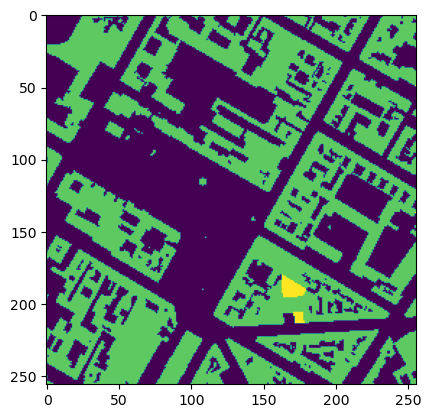

In [9]:
# par 33185 22549
# nyc 19302 24626

gdf = gpd.read_feather('data/osm/par.feather')
elapsed = time.time()
i = 33185
j = 22549 
zoom=16
bb0 = num2deg(i,j,zoom)
bb1 = num2deg(i+1,j+1,zoom)
bb0 = invtransformer.transform(bb0[0],bb0[1])
bb1 = invtransformer.transform(bb1[0],bb1[1])
bbox = box(bb0[0],bb0[1],bb1[0],bb1[1])
# filtered = gdf.cx[bb0[0]:bb1[0],bb0[1]:bb1[1]]
filtered = gdf.loc[gdf.sindex.intersection(bbox.bounds)]
# print(time.time() - elapsed)

proxy = pd.DataFrame({'min_height': 0, 'height': 0, 'geometry': bbox}, index=[filtered.size])
proxy = gpd.GeoDataFrame(proxy)
proxy.crs = '3395'

clipped = gpd.clip(filtered, proxy)

intersection = pd.concat([proxy, clipped], ignore_index=True)
intersection = intersection[intersection.geom_type.isin(['Polygon', 'MultiPolygon'])]

# paris: remove certain buildings to check the impact of shadow in park
# intersection = intersection.drop([189, 190, 195, 301, 166, 167, 169, 170, 168, 172, 173, 177, 174,175, 176, 178, 180, 183, 164, 147, 143, 142, 141, 38, 39, 161])

# nyc: remove certain buildings to check the impact of shadow in park
# intersection = intersection.drop([ 192, 191, 190, 178, 177, 176, 175, 189, 188, 174,163, 162])

if intersection.size > 0:
    intersection = sp.GeoDataFrame(intersection)
    # print(intersection.iloc[7]['geometry'])

    values = cvs.polygons(intersection, geometry='geometry', agg=ds.mean("height")).to_numpy()
    values = np.flipud(values)

    plt.imshow(values / 550)
    plt.show()
    cv2.imwrite('temp.png', 255.0 * (values / 550)) # cv2.imwrite stores the numpy array as integers into a png file. we lose float precision of building heights

In [1]:
# Plot building with their index values

# intersection_gdf = intersection.to_geopandas()
# gdf = intersection_gdf[1:].copy()

# gdf['centroid'] = gdf.geometry.centroid

# fig, ax = plt.subplots(figsize=(10, 10))
# gdf.plot(ax=ax, edgecolor='black', facecolor='none')

# for idx, row in gdf.iterrows():
#     centroid = row['centroid']
#     index = row.name
#     ax.text(centroid.x, centroid.y, str(index), ha='center', va='center', fontsize=10)

# plt.title('GeoPandas DataFrame with Polygon Indices')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# # Display the plot
# plt.show()